In [1]:
import numpy as np
import matplotlib.pyplot as plt


Gaussian Function:

$$
f(x) = a e^{-\frac{(x-b)^2}{2c^2}}
$$

In [2]:
def pulse_profile(pulse_length, pulse_type='gaussian', pulse_sigma=2):
    if pulse_type == 'square':
        pulse = np.ones(pulse_length)
    elif pulse_type == 'left triangle':
        pulse = np.linspace(1,0, pulse_length)
    elif pulse_type == 'right triangle':
        pulse = np.linspace(0,1, pulse_length)
    elif pulse_type == 'triangle':
        nleft = pulse_length//2
        nright = pulse_length-nleft
        pulse = np.concatenate([np.linspace(0,1, nleft, endpoint=False), np.linspace(1,0, nright)])
    elif pulse_type == 'gaussian':
        x = np.linspace(-10, 10, pulse_length)
        pulse = np.exp(-x**2/(2*(pulse_sigma**2)))
    else:
        raise ValueError(f'Invalid pulse_type: {pulse_type}')

    return pulse


Text(0.5, 1.0, 'Pulse Profiles (Pulse Width 40 over 100 samples')

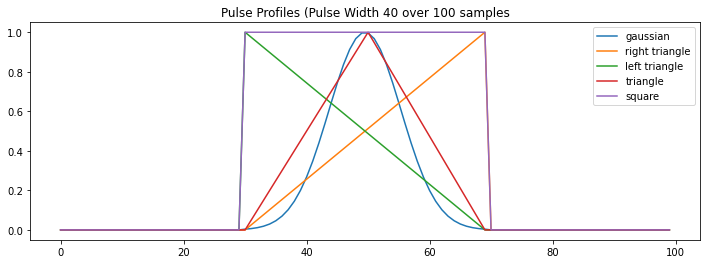

In [5]:
fig, ax = plt.subplots( figsize=(12,4))
for t in ['gaussian', 'right triangle', 'left triangle', 'triangle', 'square']:
    zz = np.concatenate([np.zeros(30), pulse_profile(40, pulse_type=t,pulse_sigma=3), np.zeros(30)])
    ax.plot(zz, label=t)

ax.legend()
ax.set_title('Pulse Profiles (Pulse Width 40 over 100 samples')


In [52]:
from scipy.stats import norm
def sig_gen(pulse_period, pulse_width = 0.05, sig_dur = 300,
            phase=np.pi, sample_rate = 1024, peaks = True,
            bias = 0.0, noise_sigma=0.05,
            pulse_type = 'gaussian', pulse_sigma=3):
    """
    pulse_period: float, pulse period in seconds
    pulse_width: float, percentage of cycle that the pulse occupies
    sig_dur: signal duration in seconds
    phase: where (in radians) pulse occurs in period
    sample_rate: int, samples per unit time (seconds)
    peaks: whether pulses go up or down
    bias: amount by which to move the signal up or down
    noise_signma: standard deviation of noise component
    pulse_type: profile of pulse: gaussian, triangle or square
    pulse_sigma: how wide pulse should be in pulse_width (only for gaussian profile)
    """

    if phase < 0.0 and phase > 2*np.pi:
            raise ValueError('Phase must be between 0 and 2 pi')

    #create a single pulse period
    samples_per_pulseperiod = int(sample_rate*pulse_period)
    samples_per_pulse = int(samples_per_pulseperiod*pulse_width)
    padleft = (samples_per_pulseperiod-samples_per_pulse)//2
    padright = samples_per_pulseperiod - samples_per_pulse - padleft
    polarity = 1 if peaks else -1
    pulse = polarity*pulse_profile(samples_per_pulse, pulse_type=pulse_type, pulse_sigma=pulse_sigma)
    sig_period = np.pad(pulse, (padleft, padright)) # pulse is in the middle of the period (at pi radians)

    #adjust the phase
    pulse_radians_per_sample = 2*np.pi/samples_per_pulseperiod
    phi = phase - np.pi # radians to offset from middle of pulse period
    phase_offset = int(phi/pulse_radians_per_sample)
    sig_period = np.roll(sig_period, phase_offset)

    # string the periods together for the duration of the signal
    nperiods = int(sig_dur/pulse_period)
    sig = np.tile(sig_period, nperiods)

    # tack on the requisite noise
    sig += norm.rvs(size=len(sig), loc=bias, scale=noise_sigma)

    return sig


In [36]:
xx=np.arange(5)
np.roll(np.pad(xx, (3,4)),4)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4])

In [38]:
def plot_dft(dft, ax, period, width,  sample_rate=1024, xlim=(0,50)):
    #print(f'Type dft: {type(dft)}, Type ax: {type(ax)}')
    freqs = np.fft.fftfreq(len(dft), d=1/sample_rate)
    ncoefs = len(dft)//2
    pwr = np.power(np.abs(dft[1:ncoefs]),2)
    max_pwr_i = pwr[1:ncoefs].argmax()+1
    max_pwr_freq = freqs[max_pwr_i]
    per = 1/max_pwr_freq

    ax.plot(freqs[1:ncoefs], pwr)
    ax.text(0.6, 0.8, f'Sample Rate: {sample_rate} s^-1',transform=ax.transAxes)
    ax.text(0.6, 0.75, f'Pulse Period: {period:.3f} s',transform=ax.transAxes)
    ax.text(0.6, 0.70, f'Pulse Width: {100*width} %',transform=ax.transAxes)
    ax.text(0.6, 0.65, f'Max Power: {pwr[max_pwr_i]:.3e}',transform=ax.transAxes)
    ax.text(0.6, 0.60, f'Max Power Freq: {max_pwr_freq:.3f} s^-1',transform=ax.transAxes)
    ax.text(0.6, 0.55, f'Calculated Period: {per:.3f} s',transform=ax.transAxes)
    ax.set_xlabel('Frequency ($s^{-1}$)')
    ax.set_xlim(xlim)


In [39]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def plot_signal(ax, sig, sample_rate=1024, plot_width=4):
    ax.plot(sig)

    #for i in range(plot_width):
    #    ax.axvline(sample_rate*i, ls=':', color='red')

    ax.set_xticks([sample_rate*i for i in range(plot_width+1)])
    ax.set_xticklabels([str(i) for i in range(plot_width+1)])
    ax.xaxis.set_minor_locator(MultipleLocator(sample_rate/4))

    #ax.tick_params(which='both', width=2)
    ax.tick_params(which='minor', length=3)
    ax.tick_params(which='major', length=7)
    ax.xaxis.grid(True, which='major')
    ax.set_xlim(0, plot_width*samples_per_second)
    ax.set_xlabel('Time (Seconds)')

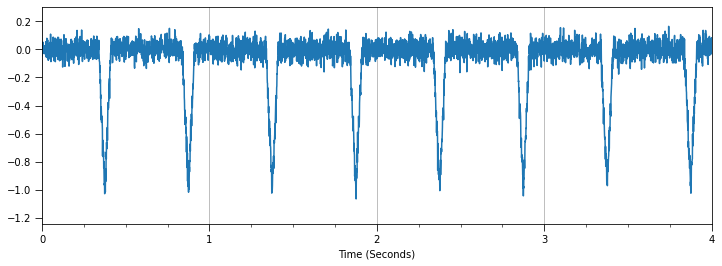

In [56]:
samples_per_second = 1024
plot_width = 4 # seconds
period = 0.5
pulse_width = 0.15

sig = sig_gen(period, pulse_width, sample_rate = samples_per_second, peaks=False, phase=3*np.pi/2,pulse_type='triangle')
fig, ax = plt.subplots(figsize=(12,4))

plot_signal(ax, sig)

In [57]:
dft = np.fft.fft(sig)

```
signal = np.array([-2, 8, 6, 4, 1, 0, 3, 5], dtype=float)
fourier = np.fft.fft(signal)
n = signal.size
timestep = 0.1
freq = np.fft.fftfreq(n, d=timestep)
```

(0.0, 50.0)

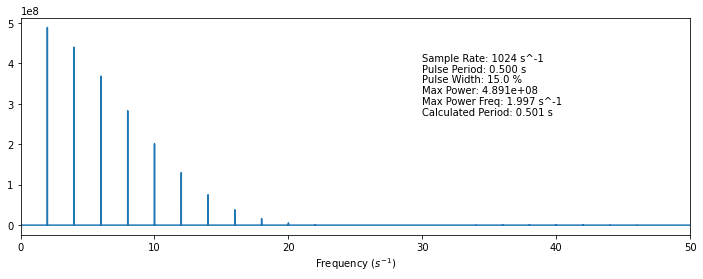

In [58]:
fig, ax = plt.subplots(figsize=(12,4))
plot_dft(dft, ax, period, pulse_width)
#ax.axvline(1/samples_per_second)
ax.set_xlim(0,50)
#ax.axvline(1/samples_per_second, color='red')

## Real Valued Signal

Use `np.fft.rfft`; returns just the positive frequencies which have all of the information.

In [10]:
dft = np.fft.fft(sig)
rft = np.fft.rfft(sig)

In [11]:
len(rft), len(dft)

(153601, 307200)

In [12]:
rft[0] == dft[0]

True

In [13]:
np.allclose(rft, dft[:len(rft)])

True

`np.fft.rfft` returns the same coefficients as the first half of `np.fft.fft`

## Peaks versus Dips

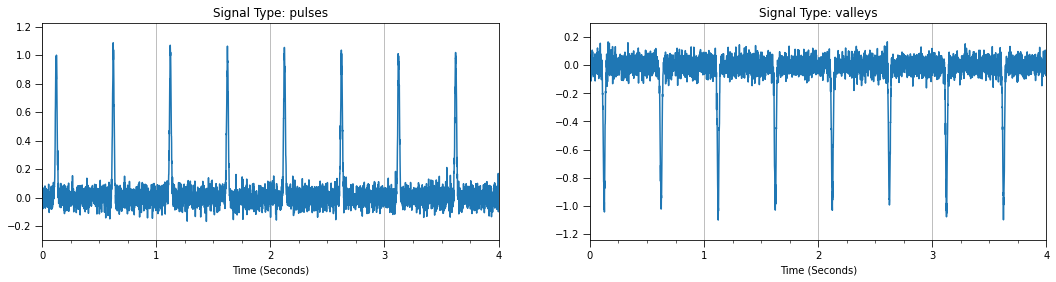

In [59]:
samples_per_second = 1024
plot_width = 4 # seconds
period = 0.5
pulse_width = 0.1

sigs = {'pulses': sig_gen(period, pulse_width, sample_rate = samples_per_second, peaks=True, phase=np.pi/2),
        'valleys': sig_gen(period, pulse_width, sample_rate = samples_per_second, peaks=False, phase=np.pi/2)}

fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax in zip(sigs, axs):
    plot_signal(ax, sigs[sig], sample_rate=samples_per_second, plot_width=plot_width)
    ax.set_title(f'Signal Type: {sig}')


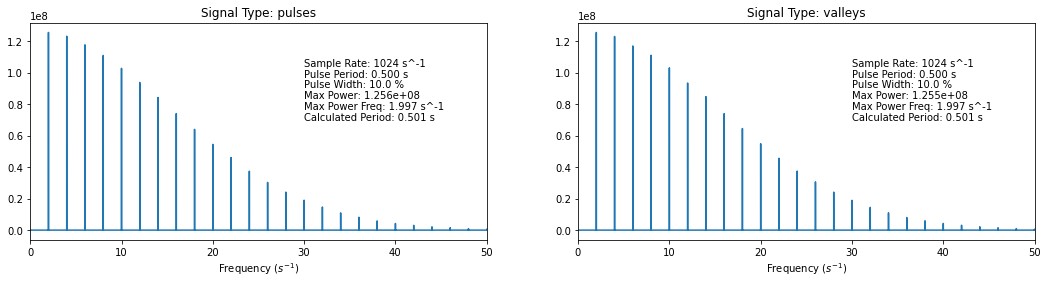

In [60]:
fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax in zip(sigs, axs): 
    plot_dft(np.fft.fft(sigs[sig]), ax, period, pulse_width)
    #ax.axvline(1/samples_per_second)
    ax.set_xlim(0,50)
    ax.set_title(f'Signal Type: {sig}')

    #ax.axvline(1/samples_per_second, color='red')

as far as the FFT is concerned, there's no apparent difference between peaks and valleys.

## Effect of Peak Width

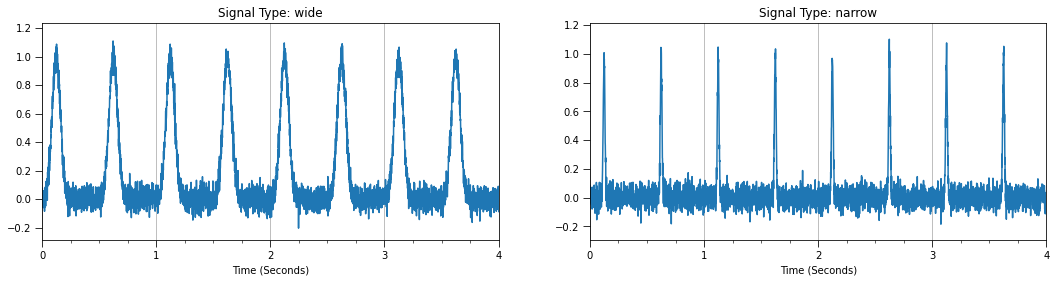

In [61]:
samples_per_second = 1024
plot_width = 4 # seconds
period = 0.5
#pulse_width = 0.1

sigs = {'wide': sig_gen(period, pulse_width=0.5, sample_rate = samples_per_second, peaks=True, phase=np.pi/2),
        'narrow': sig_gen(period, pulse_width=0.1, sample_rate = samples_per_second, peaks=True, phase=np.pi/2)}

fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax in zip(sigs, axs):
    plot_signal(ax,sigs[sig])
    ax.set_title(f'Signal Type: {sig}')


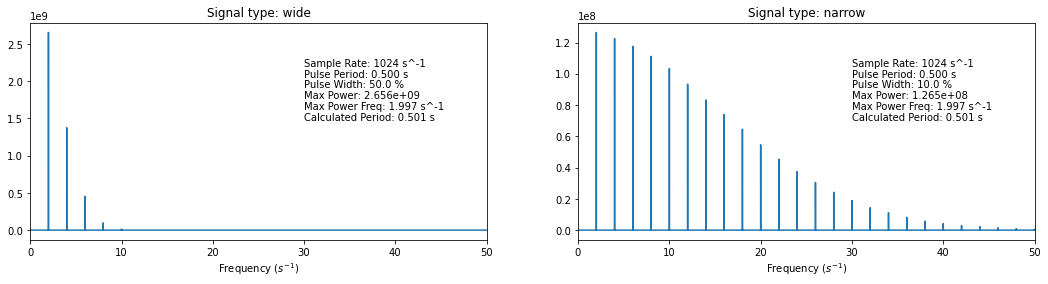

In [62]:
fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax, pw in zip(sigs, axs, [0.5,0.1]): 
    plot_dft(np.fft.fft(sigs[sig]), ax, period=period, width=pw, sample_rate=samples_per_second)
    ax.set_title(f'Signal type: {sig}')


Looks like the harmonics fall off faster as the peak width increases.

## Effect of non-Integral Pulse Periods

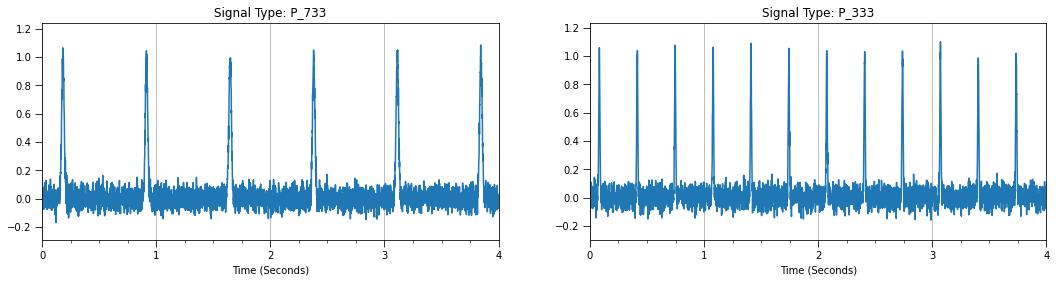

In [63]:
samples_per_second = 1024
plot_width = 4 # seconds
#period = 0.5
pulse_width = 0.1

sigs = {'P_733': sig_gen(0.733, pulse_width=pulse_width, sample_rate = samples_per_second, peaks=True, phase=np.pi/2),
        'P_333': sig_gen(0.333, pulse_width=pulse_width, sample_rate = samples_per_second, peaks=True, phase=np.pi/2)}

fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax in zip(sigs, axs):
    plot_signal(ax,sigs[sig])
    ax.set_title(f'Signal Type: {sig}')


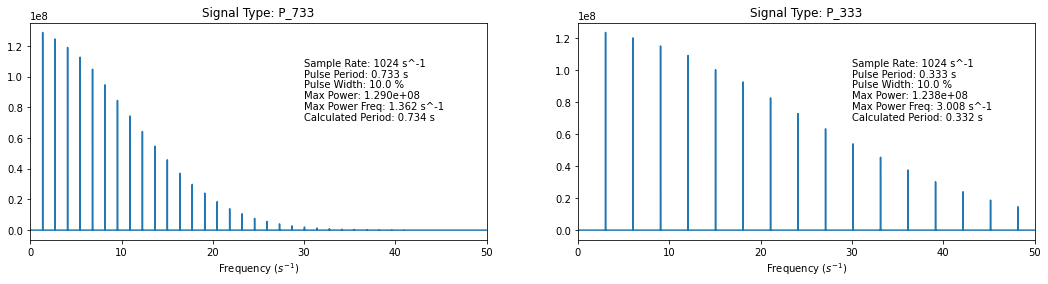

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax, pp in zip(sigs, axs, [0.733,0.333]): 
    plot_dft(np.fft.fft(sigs[sig]), ax, period=pp, width=pulse_width)


    ax.set_title(f'Signal Type: {sig}')


In [65]:
def elfoldo(sig, period, sample_rate):
    nsamp = int(period*sample_rate)
    nperiods = len(sig)//nsamp
    print(f'Samples per period: {nsamp}, Number of Periods: {nperiods}')
    return sig[:nperiods*nsamp].reshape(nperiods, nsamp)

In [66]:
def get_period(dft, sample_rate):
    freqs = np.fft.fftfreq(len(dft), d=1/sample_rate)
    ncoefs = len(dft)//2
    pwr = np.power(np.abs(dft[1:ncoefs]),2)
    max_pwr_i = pwr[1:ncoefs].argmax()+1
    max_pwr_freq = freqs[max_pwr_i]

    stats = {
        "max_pwr_i": max_pwr_i,
        "max_pwr_freq" : max_pwr_freq,
        "Period": 1/max_pwr_freq
    }

    return stats



In [67]:
dft = np.fft.fft(sigs['P_733'])
ps = get_period(dft, sample_rate=samples_per_second)

In [68]:
folded=0
folded = elfoldo(sigs['P_733'], ps['Period'], samples_per_second)


Samples per period: 751, Number of Periods: 408


In [44]:
#folded[90:100,400:410]=folded.max()

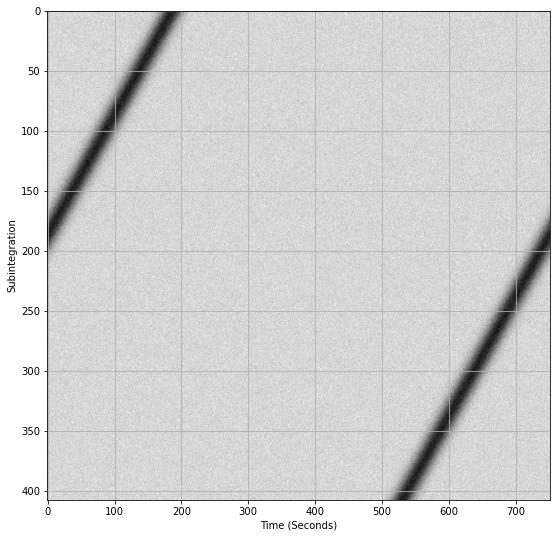

In [69]:
nsamp = folded.shape[1]
fig, ax = plt.subplots( figsize=(9,9))
ax.imshow(folded,  cmap='gray_r', aspect='auto' )
ax.set_ylabel('Subintegration')
ax.set_xlabel('Time (Seconds)')
ax.grid()

Text(0.5, 0, 'Time (Seconds)')

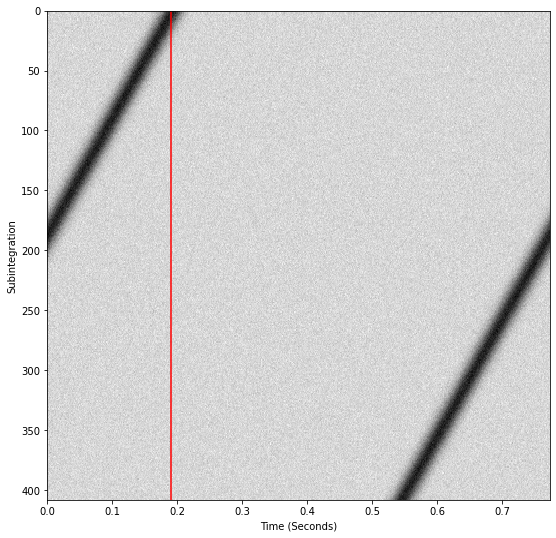

In [70]:
nsamp = folded.shape[1]
fig, ax = plt.subplots( figsize=(9,9))
ax.imshow(folded,  cmap='gray_r', interpolation='none', extent=[0,0.773,folded.shape[0], 0], aspect='auto' )
ax.axvline(0.19, color='red')
ax.set_ylabel('Subintegration')
ax.set_xlabel('Time (Seconds)')

In [30]:
sigs['P_733'].size

306750

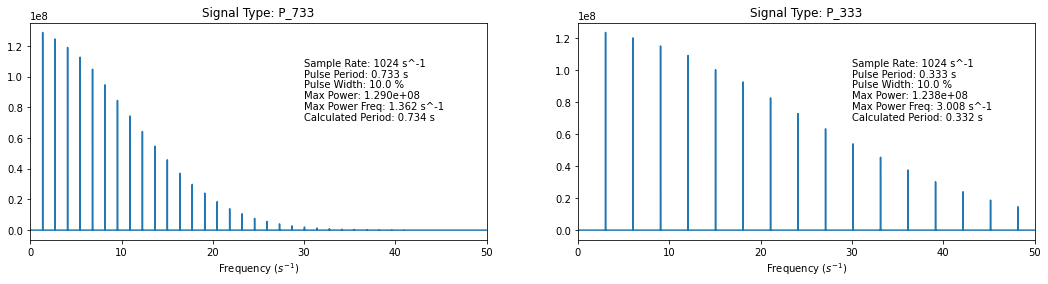

In [71]:
fig, axs = plt.subplots(ncols=2, figsize=(18,4))

for sig, ax, pp in zip(sigs, axs, [0.733,0.333]): 
    plot_dft(np.fft.fft(sigs[sig]), ax, period=pp, width=pulse_width)


    ax.set_title(f'Signal Type: {sig}')

In [75]:
freqs = np.fft.rfftfreq(len(sigs['P_733']), d=1/samples_per_second)
dft = np.fft.fft(sigs['P_733'])
ps = get_period(dft, sample_rate=samples_per_second)

In [76]:
ps

{'max_pwr_i': 408,
 'max_pwr_freq': 1.3619951100244498,
 'Period': 0.7342170266544118}

In [80]:
np.abs(1/freqs[400:415] - 0.733)

array([0.01590137, 0.01403378, 0.01217549, 0.01032642, 0.0084865 ,
       0.00665567, 0.00483386, 0.003021  , 0.00121703, 0.00057812,
       0.00236452, 0.00414222, 0.00591129, 0.0076718 , 0.0094238 ])